In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# https://arxiv.org/pdf/2006.11239.pdf

import torch
from torch import optim, nn

import json
from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image, load_contour
from UNet import UNet, UNet_conditional
from torchvision.transforms import v2
from matplotlib import pyplot as plt

device = "cuda"

pimages = load_dataset().to(device)
pimages.shape

with open("labels/pokedex.json") as json_data:
    data = json.load(json_data)

height = [float(str(d['profile']['height']).split()[0]) for d in data]
height = torch.tensor(height, device=device)
#height

types = [d['type'] for d in data]
all_types = list(set([d[0] for d in types]))

def get_index(tp):
    if len(tp) == 1:
        return all_types.index(tp[0]), len(all_types)
    return all_types.index(tp[0]), all_types.index(tp[1])

types = torch.tensor([get_index(t) for t in types], device=device)

contour = load_contour().to(device)
contour.shape

torch.Size([3, 386, 1, 64, 64])

In [2]:
T = 200
beta = torch.linspace(0.04, 0.04, T, device=device)

alpha = 1 - beta

alpha_ = torch.zeros(T, device=device)

for i in range(T):
    alpha_[i] = torch.prod(alpha[0:i+1])

alpha_[-1]

tensor(0.0003, device='cuda:0')

In [3]:
alpha_

tensor([9.6000e-01, 9.2160e-01, 8.8474e-01, 8.4935e-01, 8.1537e-01, 7.8276e-01,
        7.5145e-01, 7.2139e-01, 6.9253e-01, 6.6483e-01, 6.3824e-01, 6.1271e-01,
        5.8820e-01, 5.6467e-01, 5.4209e-01, 5.2040e-01, 4.9959e-01, 4.7960e-01,
        4.6042e-01, 4.4200e-01, 4.2432e-01, 4.0735e-01, 3.9106e-01, 3.7541e-01,
        3.6040e-01, 3.4598e-01, 3.3214e-01, 3.1886e-01, 3.0610e-01, 2.9386e-01,
        2.8210e-01, 2.7082e-01, 2.5999e-01, 2.4959e-01, 2.3960e-01, 2.3002e-01,
        2.2082e-01, 2.1199e-01, 2.0351e-01, 1.9537e-01, 1.8755e-01, 1.8005e-01,
        1.7285e-01, 1.6593e-01, 1.5930e-01, 1.5292e-01, 1.4681e-01, 1.4094e-01,
        1.3530e-01, 1.2989e-01, 1.2469e-01, 1.1970e-01, 1.1491e-01, 1.1032e-01,
        1.0591e-01, 1.0167e-01, 9.7602e-02, 9.3698e-02, 8.9950e-02, 8.6352e-02,
        8.2898e-02, 7.9582e-02, 7.6399e-02, 7.3343e-02, 7.0409e-02, 6.7593e-02,
        6.4889e-02, 6.2294e-02, 5.9802e-02, 5.7410e-02, 5.5113e-02, 5.2909e-02,
        5.0793e-02, 4.8761e-02, 4.6810e-

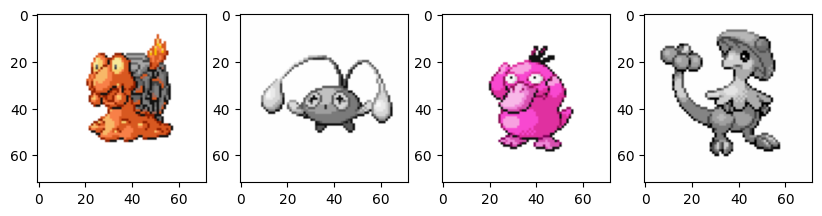

In [4]:
transform = v2.Compose([
    v2.Pad(6, 1.0),
    v2.RandomCrop((64+6, 64+6)),
    v2.Pad(1, 1.0),
    v2.RandomApply([v2.ColorJitter()], 0.2),
    v2.RandomApply([v2.RandomChannelPermutation()], 0.2),
    v2.RandomGrayscale(p = 0.2),
])

source = randint(0, 2)
batch = torch.randperm(385)[:4]
x0 = pimages[source, batch]
x0 = torch.stack([transform(x) for x in x0], dim=0)

fig, axes = plt.subplots(1, 4, figsize=(10, 10))
plot_image(x0[0], axes[0])
plot_image(x0[1], axes[1])
plot_image(x0[2], axes[2])
plot_image(x0[3], axes[3])
plt.show()

In [5]:
def isigmoid(x):
    eps = 0.05
    return torch.log(x + eps) - torch.log(1 - x + eps)

In [6]:
model = UNet_conditional(3, 3, num_classes=len(all_types) + 1).to(device)

@torch.no_grad
def generate_image():
    model.eval()

    N = 3

    x = torch.randn((N, 3, 72, 72), device=device)

    ty = [["Grass"], ["Fire"], ["Water"]]
    ty = torch.tensor([get_index(t) for t in ty], device=device)
    
    for t in reversed(range(T)):
        tt = torch.tensor([t] * N, device=device)

        z = torch.randn_like(x)
        if t == 0:
            z *= 0

        #x0 = model(x, tt)
        #x = torch.sqrt(alpha_[t]) * x0 + torch.sqrt(1-alpha_[t]) * z

        e = model(x, tt, ty) * (1 - alpha[t]) / torch.sqrt(1 - alpha_[t])
        x = (1 / torch.sqrt(alpha[t])) * (x - e) + z * torch.sqrt(beta[t])
    
    x = torch.sigmoid(x)
    
    fig, axes = plt.subplots(1, N, figsize=(10, 10))
    for i in range(N):
        plot_image(x[i], axes[i])
    plt.show()

    model.train()

In [7]:
#sd = torch.load("model.pt")
#model.load_state_dict(sd)

#generate_image()

  0%|                                                                                                                                                | 0/100001 [00:00<?, ?it/s]

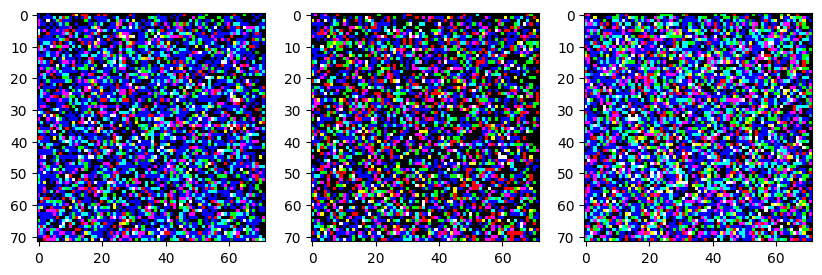

0.01979066:   1%|█▏                                                                                                                     | 1000/100001 [02:06<3:21:36,  8.18it/s]

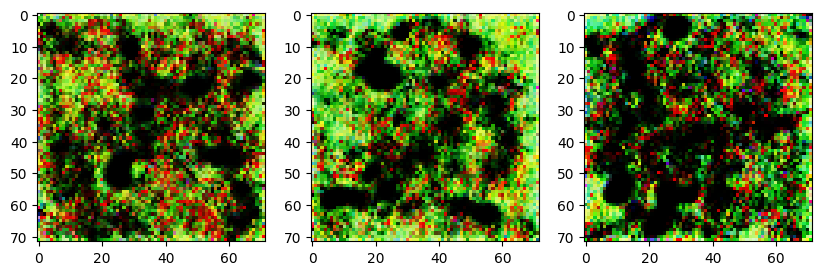

0.04921931:   2%|██▍                                                                                                                    | 2000/100001 [04:11<3:19:22,  8.19it/s]

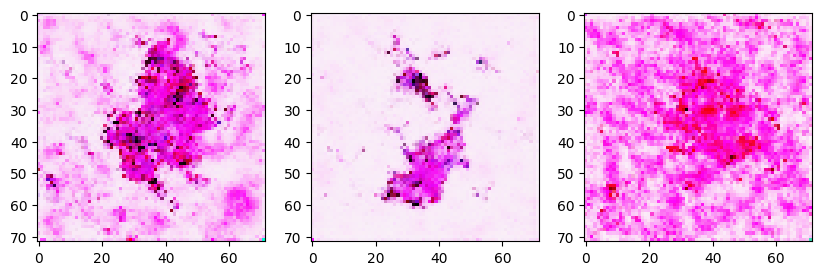

0.03103831:   3%|███▌                                                                                                                   | 3000/100001 [06:17<3:17:35,  8.18it/s]

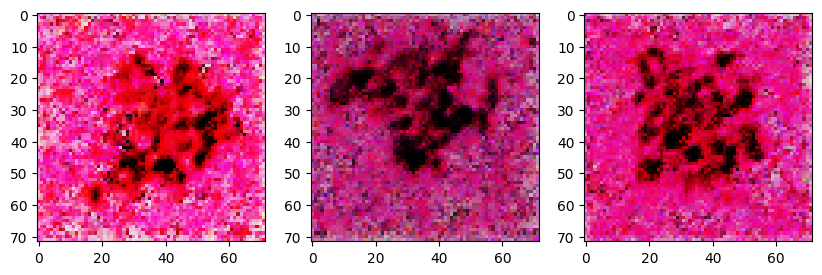

0.02218910:   4%|████▊                                                                                                                  | 4000/100001 [08:22<3:15:21,  8.19it/s]

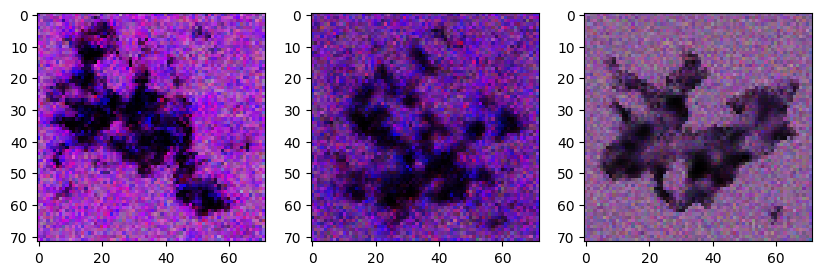

0.02493934:   5%|█████▉                                                                                                                 | 5000/100001 [10:28<3:13:12,  8.20it/s]

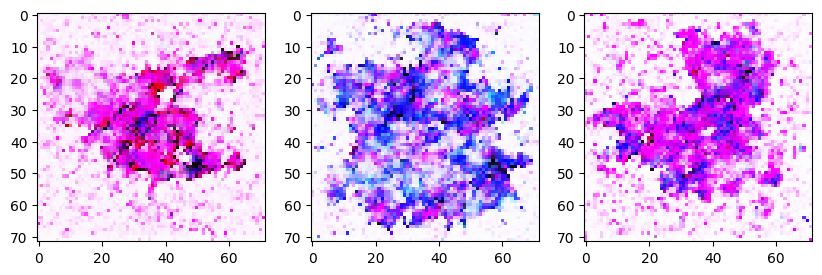

0.02304528:   6%|███████▏                                                                                                               | 6000/100001 [12:33<3:11:47,  8.17it/s]

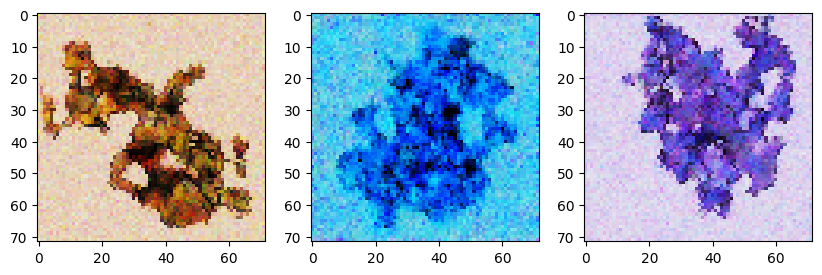

0.01626441:   7%|████████▎                                                                                                              | 7000/100001 [14:39<3:08:54,  8.20it/s]

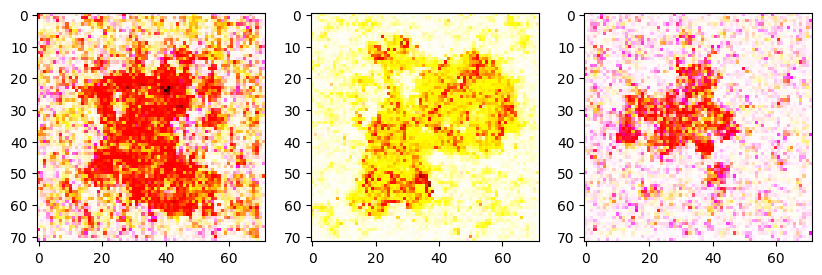

0.03370789:   8%|█████████▌                                                                                                             | 8000/100001 [16:45<3:07:04,  8.20it/s]

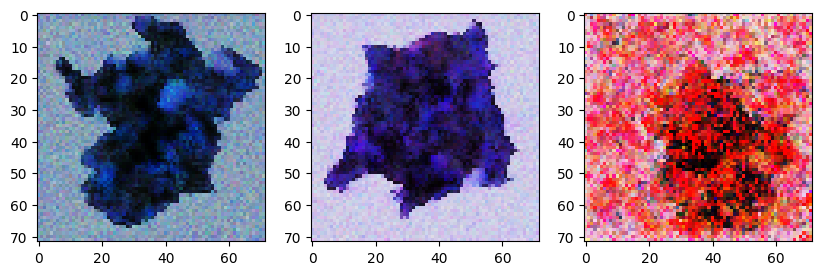

0.01653080:   9%|██████████▋                                                                                                            | 9000/100001 [18:50<3:04:37,  8.21it/s]

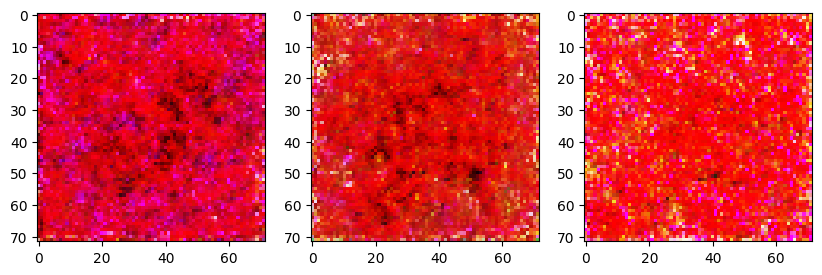

0.02139445:  10%|███████████▊                                                                                                          | 10000/100001 [20:56<3:02:49,  8.20it/s]

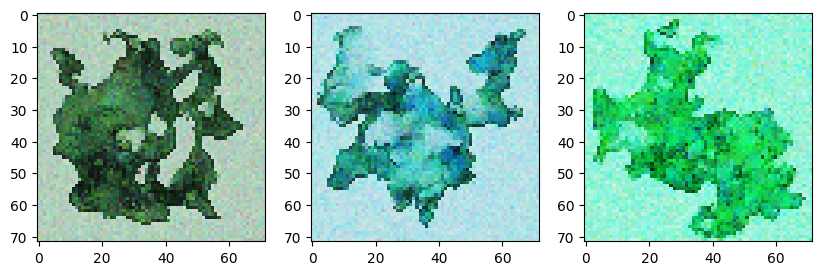

0.01469444:  11%|████████████▉                                                                                                         | 11000/100001 [23:01<3:01:11,  8.19it/s]

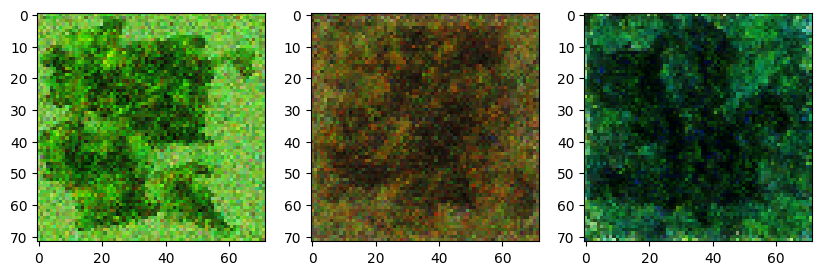

0.03109959:  12%|██████████████▏                                                                                                       | 12000/100001 [25:07<2:58:40,  8.21it/s]

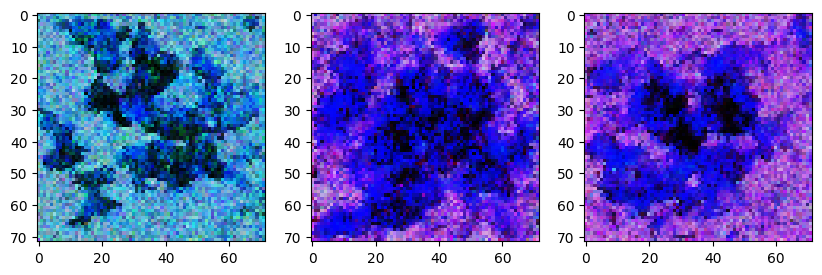

0.01293112:  13%|███████████████▎                                                                                                      | 13000/100001 [27:12<2:57:03,  8.19it/s]

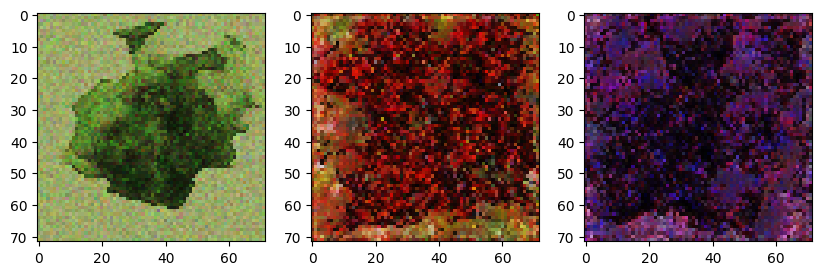

0.00903624:  14%|████████████████▌                                                                                                     | 14000/100001 [29:18<2:54:37,  8.21it/s]

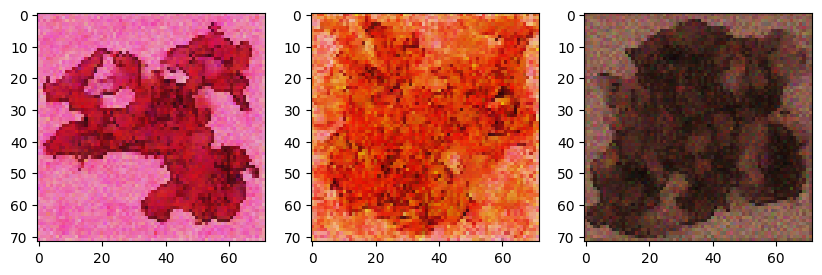

0.03430941:  15%|█████████████████▋                                                                                                    | 15000/100001 [31:23<2:52:28,  8.21it/s]

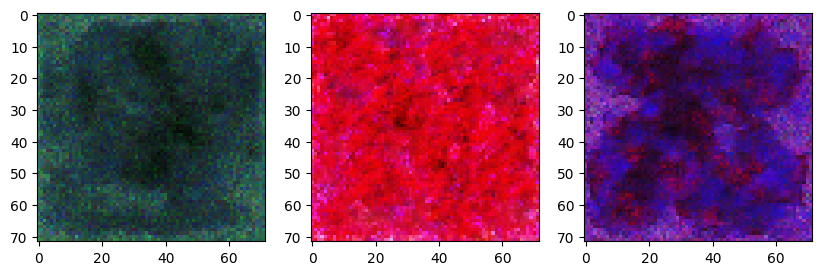

0.02562378:  16%|██████████████████▉                                                                                                   | 16000/100001 [33:29<2:50:57,  8.19it/s]

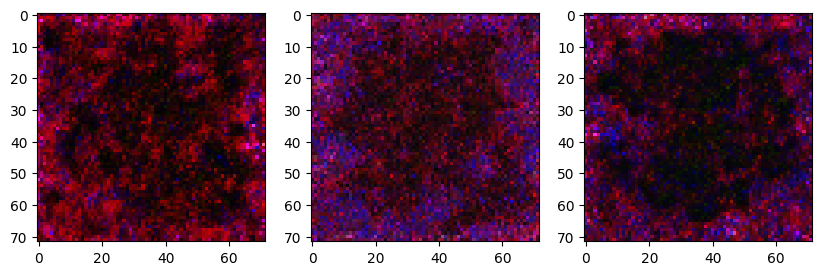

0.02171266:  17%|████████████████████                                                                                                  | 17000/100001 [35:35<2:49:00,  8.18it/s]

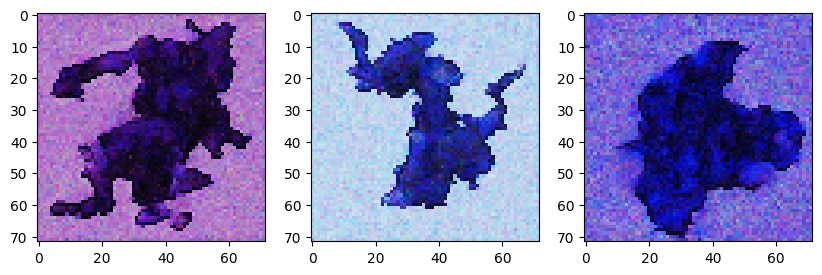

0.01606769:  18%|█████████████████████▏                                                                                                | 18000/100001 [37:40<2:46:56,  8.19it/s]

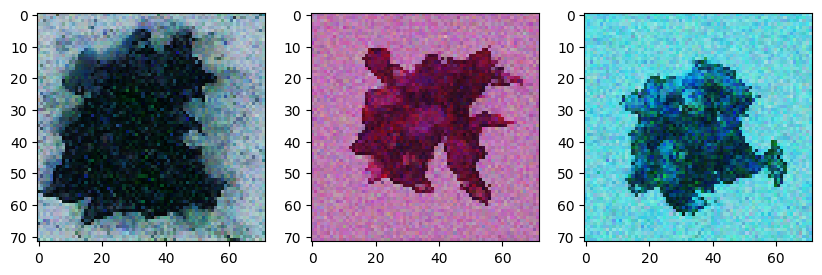

0.02376498:  19%|██████████████████████▍                                                                                               | 19000/100001 [39:46<2:44:49,  8.19it/s]

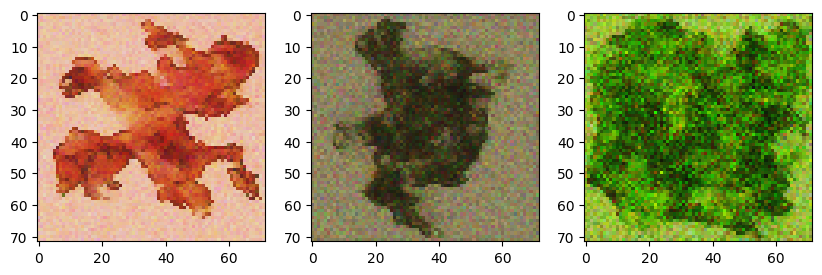

0.00570657:  20%|███████████████████████▌                                                                                              | 20000/100001 [41:51<2:42:32,  8.20it/s]

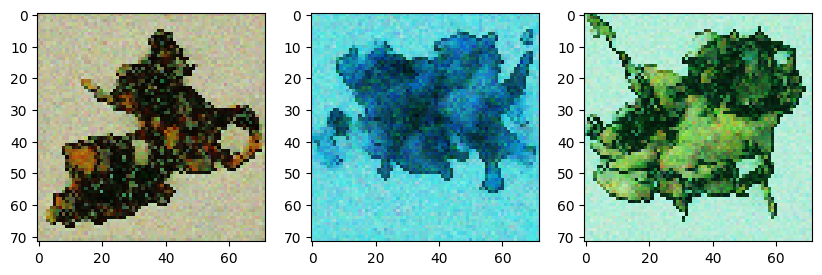

0.01431222:  21%|████████████████████████▊                                                                                             | 21000/100001 [43:57<2:40:25,  8.21it/s]

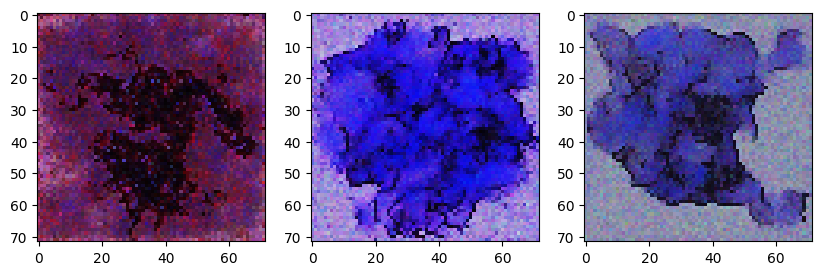

0.01724659:  22%|█████████████████████████▉                                                                                            | 22000/100001 [46:03<2:38:56,  8.18it/s]

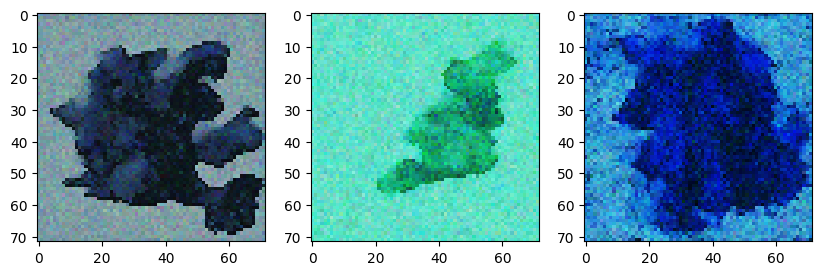

0.01055925:  23%|███████████████████████████▏                                                                                          | 23000/100001 [48:08<2:36:36,  8.19it/s]

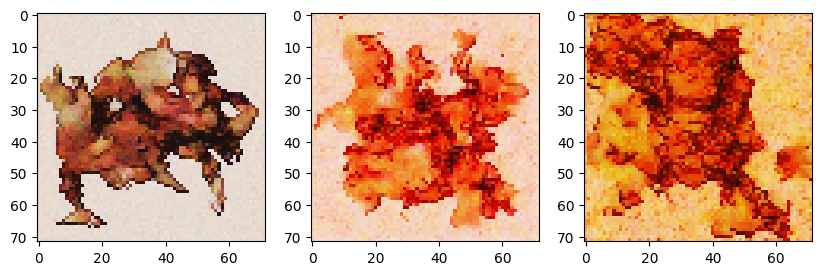

0.01374247:  24%|████████████████████████████▎                                                                                         | 24000/100001 [50:14<2:34:49,  8.18it/s]

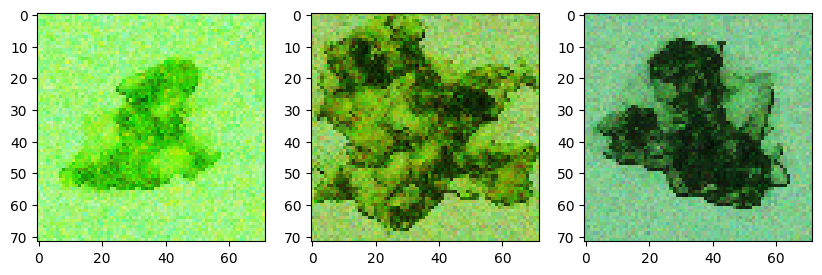

0.00812039:  25%|█████████████████████████████▍                                                                                        | 25000/100001 [52:19<2:32:26,  8.20it/s]

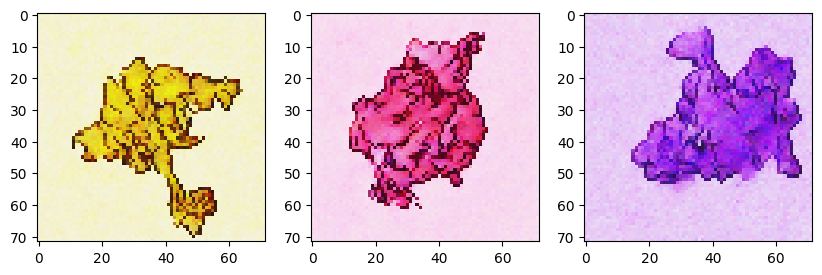

0.01383564:  26%|██████████████████████████████▋                                                                                       | 26000/100001 [54:25<2:30:17,  8.21it/s]

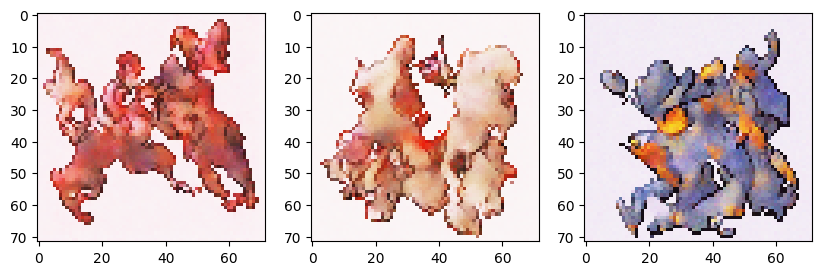

0.01151774:  27%|███████████████████████████████▊                                                                                      | 27000/100001 [56:30<2:28:51,  8.17it/s]

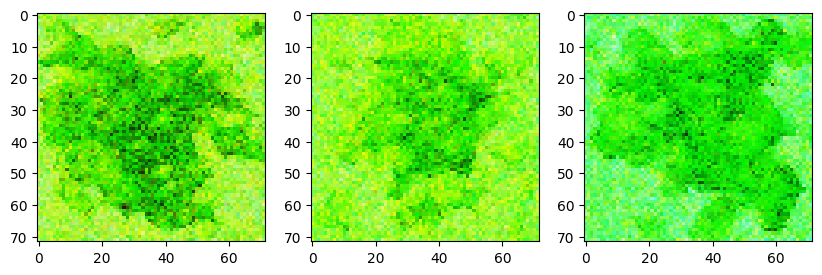

0.02548344:  28%|█████████████████████████████████                                                                                     | 28000/100001 [58:36<2:26:54,  8.17it/s]

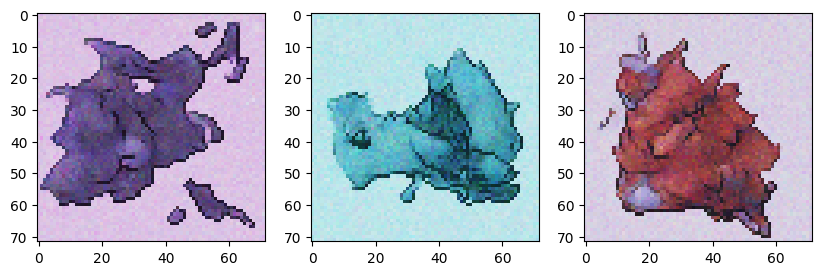

0.01176086:  29%|█████████████████████████████████▋                                                                                  | 29000/100001 [1:00:41<2:24:14,  8.20it/s]

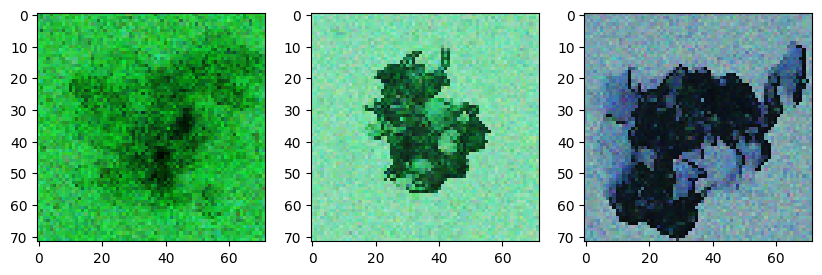

0.03547671:  30%|██████████████████████████████████▊                                                                                 | 30000/100001 [1:02:47<2:22:17,  8.20it/s]

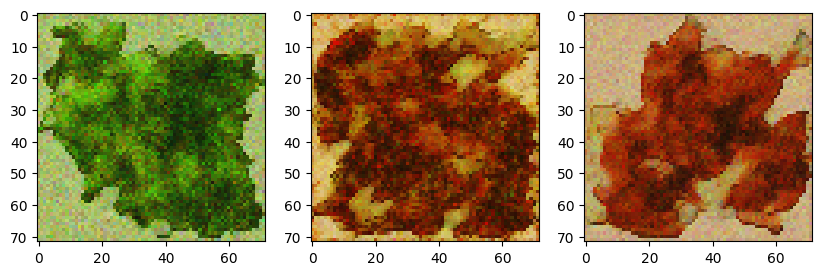

0.01376883:  31%|███████████████████████████████████▉                                                                                | 31000/100001 [1:04:53<2:20:28,  8.19it/s]

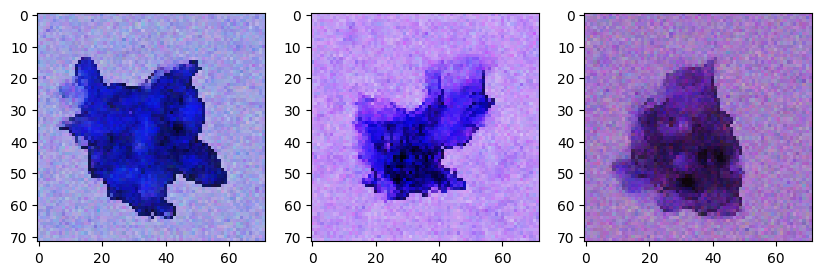

0.01782190:  32%|█████████████████████████████████████                                                                               | 32000/100001 [1:06:58<2:18:06,  8.21it/s]

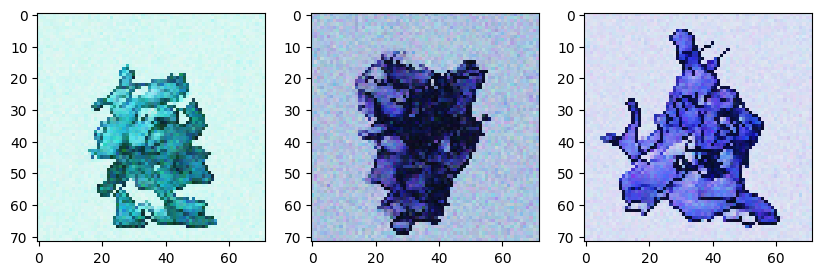

0.00858169:  33%|██████████████████████████████████████▎                                                                             | 33000/100001 [1:09:04<2:16:24,  8.19it/s]

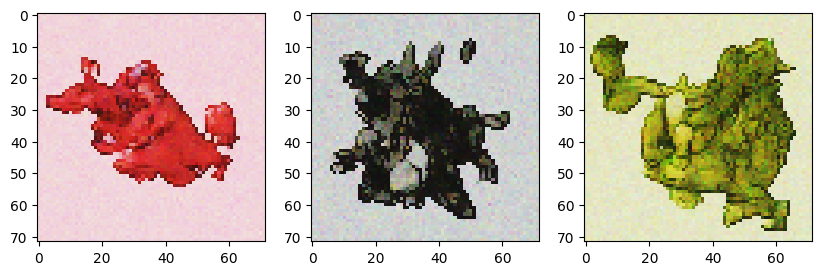

0.01446135:  34%|███████████████████████████████████████▍                                                                            | 34000/100001 [1:11:09<2:14:12,  8.20it/s]

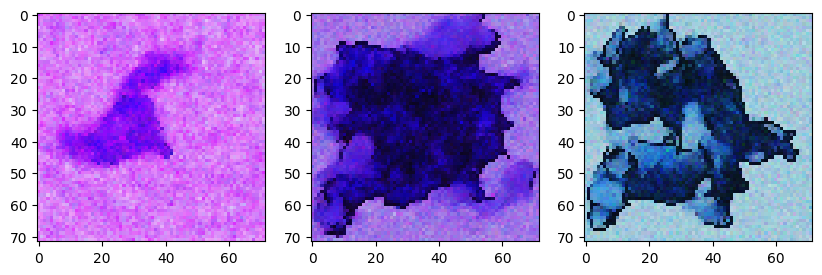

0.01557844:  35%|████████████████████████████████████████▌                                                                           | 35000/100001 [1:13:15<2:12:24,  8.18it/s]

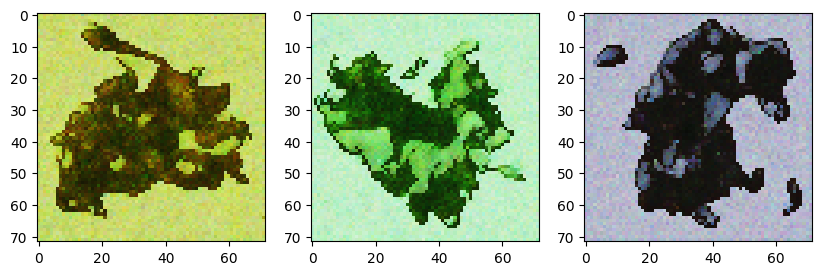

0.02096777:  36%|█████████████████████████████████████████▊                                                                          | 36000/100001 [1:15:20<2:10:01,  8.20it/s]

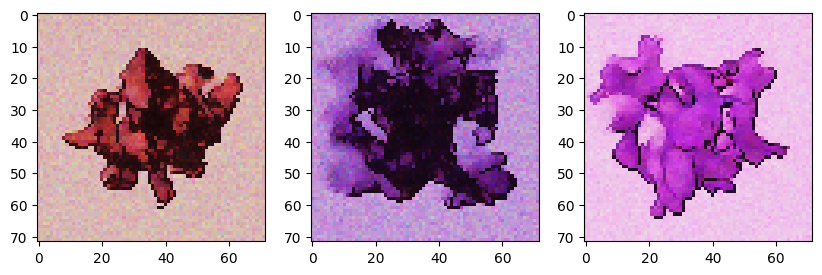

0.02493419:  37%|██████████████████████████████████████████▉                                                                         | 37000/100001 [1:17:26<2:08:04,  8.20it/s]

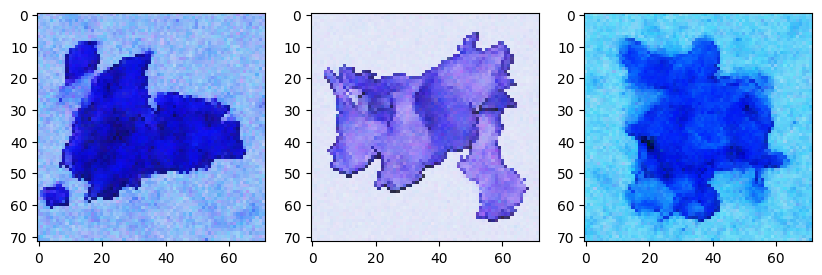

0.02044244:  38%|████████████████████████████████████████████                                                                        | 38000/100001 [1:19:31<2:05:44,  8.22it/s]

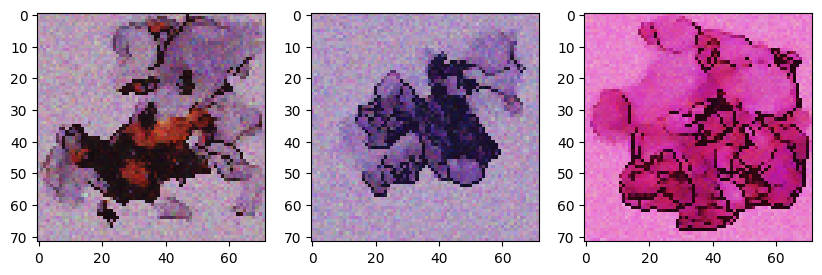

0.02279605:  39%|█████████████████████████████████████████████▏                                                                      | 39000/100001 [1:21:37<2:04:20,  8.18it/s]

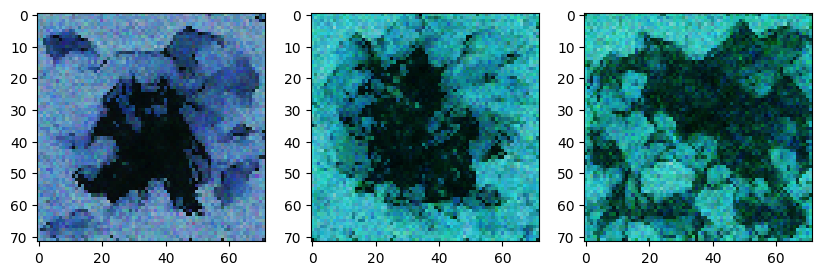

0.00837633:  40%|██████████████████████████████████████████████▍                                                                     | 40000/100001 [1:23:43<2:02:18,  8.18it/s]

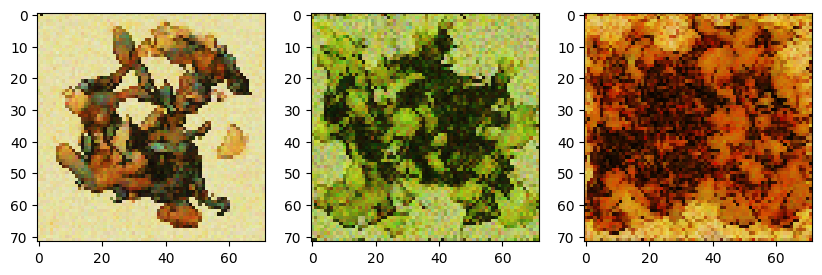

0.01249392:  41%|███████████████████████████████████████████████▌                                                                    | 41000/100001 [1:25:48<2:00:19,  8.17it/s]

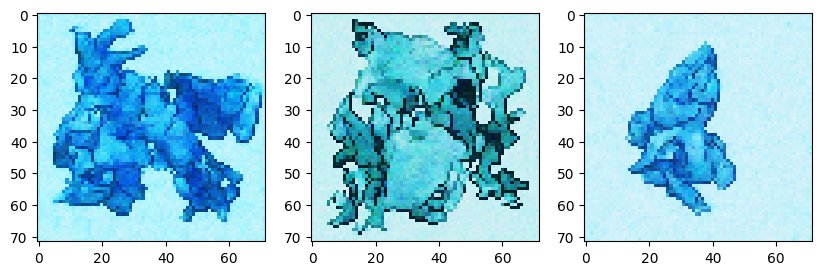

0.01740974:  42%|████████████████████████████████████████████████▋                                                                   | 42000/100001 [1:27:54<1:57:16,  8.24it/s]

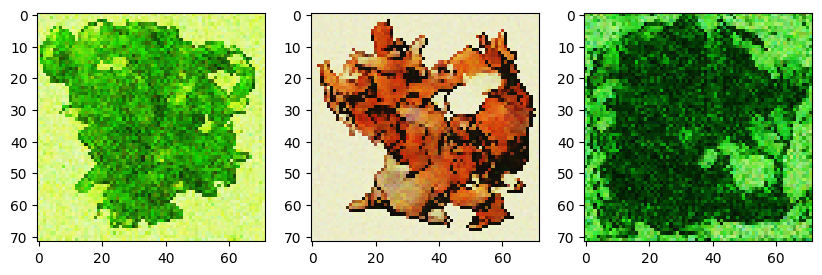

0.01562816:  43%|█████████████████████████████████████████████████▉                                                                  | 43000/100001 [1:29:59<1:56:05,  8.18it/s]

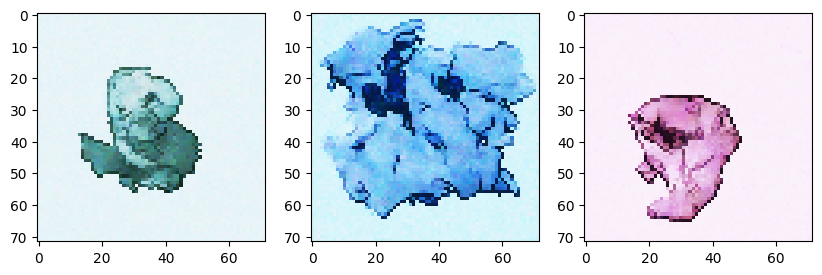

0.01657919:  44%|███████████████████████████████████████████████████                                                                 | 44000/100001 [1:32:05<1:54:04,  8.18it/s]

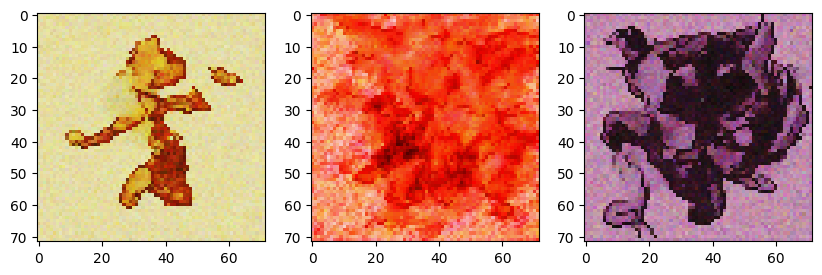

0.00600213:  45%|████████████████████████████████████████████████████▏                                                               | 45000/100001 [1:34:11<1:51:45,  8.20it/s]

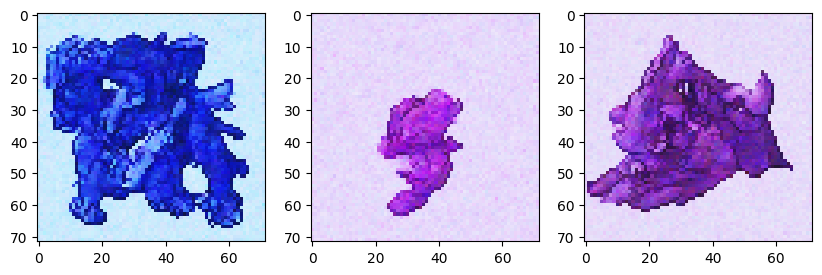

0.01393607:  46%|█████████████████████████████████████████████████████▎                                                              | 46000/100001 [1:36:16<1:49:55,  8.19it/s]

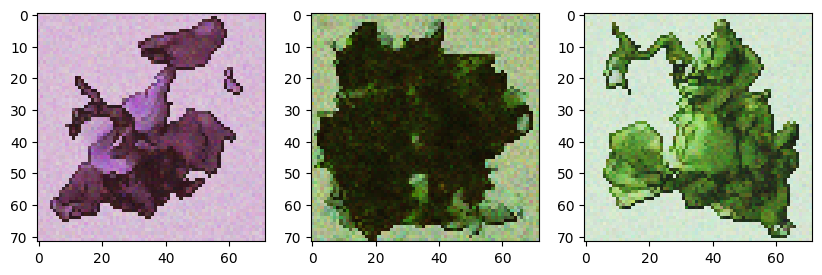

0.01694046:  47%|██████████████████████████████████████████████████████▌                                                             | 47000/100001 [1:38:22<1:47:38,  8.21it/s]

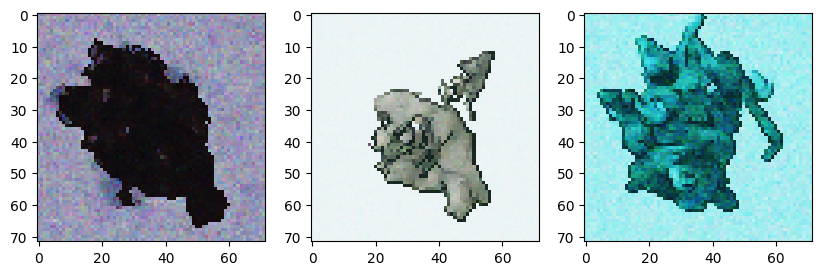

0.02062573:  48%|███████████████████████████████████████████████████████▋                                                            | 48000/100001 [1:40:28<1:45:57,  8.18it/s]

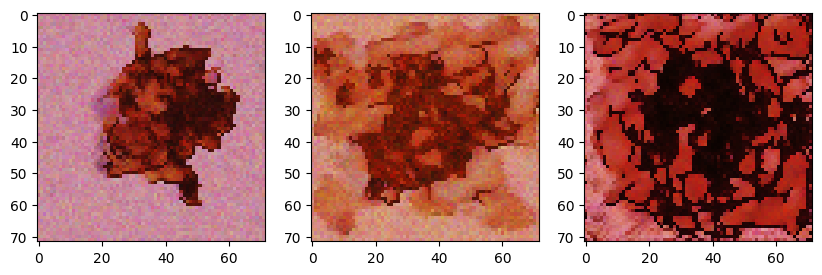

0.01560830:  49%|████████████████████████████████████████████████████████▊                                                           | 49000/100001 [1:42:33<1:43:44,  8.19it/s]

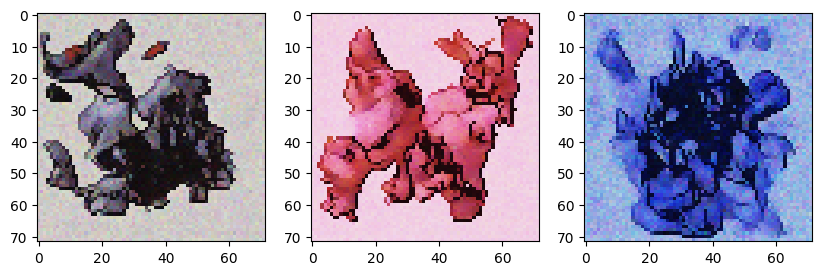

0.01416843:  50%|█████████████████████████████████████████████████████████▉                                                          | 50000/100001 [1:44:39<1:41:41,  8.20it/s]

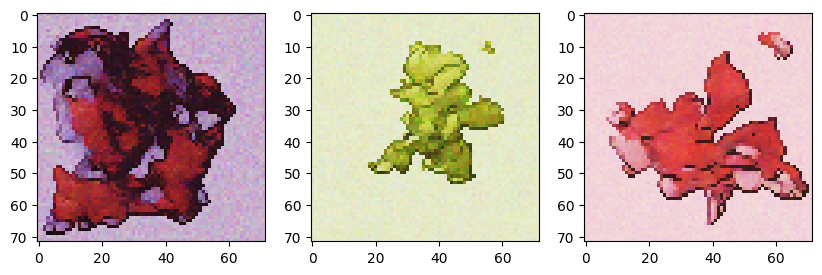

0.00886191:  51%|███████████████████████████████████████████████████████████▏                                                        | 51000/100001 [1:46:45<1:39:38,  8.20it/s]

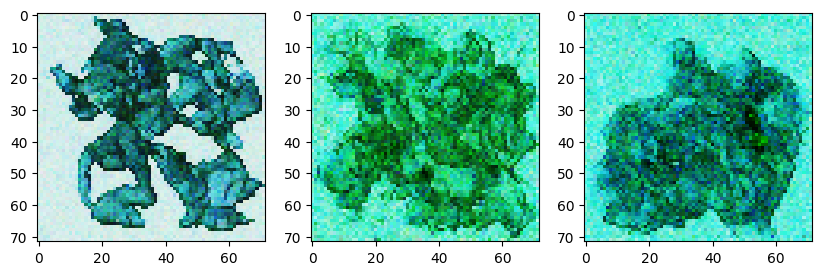

0.01741141:  52%|████████████████████████████████████████████████████████████▎                                                       | 52000/100001 [1:48:50<1:37:32,  8.20it/s]

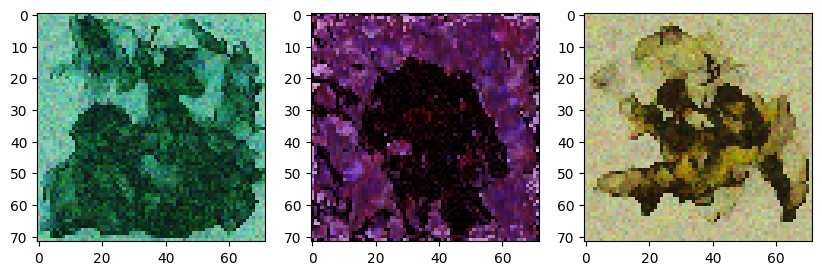

0.01644996:  53%|█████████████████████████████████████████████████████████████▍                                                      | 53000/100001 [1:50:56<1:35:43,  8.18it/s]

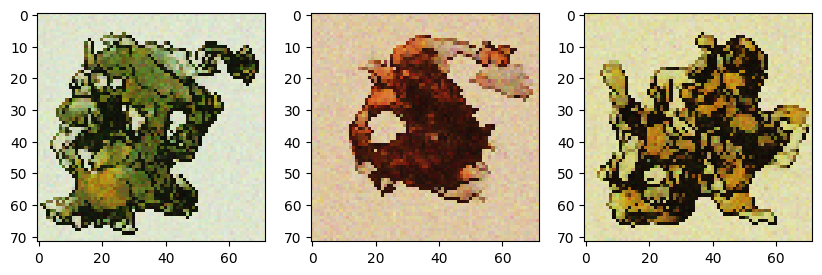

0.01003752:  54%|██████████████████████████████████████████████████████████████▋                                                     | 54000/100001 [1:53:01<1:33:33,  8.19it/s]

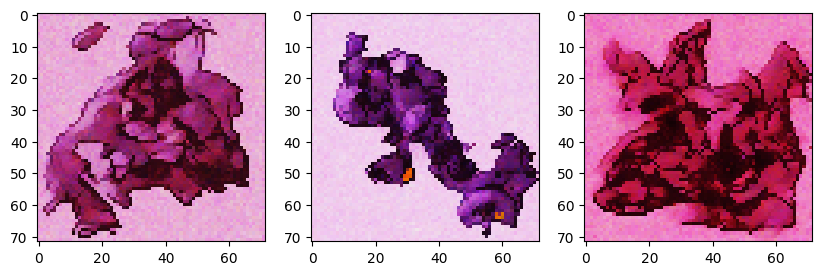

0.02281036:  55%|███████████████████████████████████████████████████████████████▊                                                    | 55000/100001 [1:55:07<1:31:33,  8.19it/s]

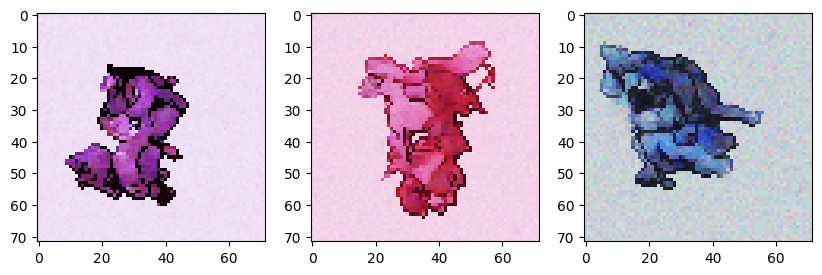

0.03193791:  56%|████████████████████████████████████████████████████████████████▉                                                   | 56000/100001 [1:57:13<1:29:23,  8.20it/s]

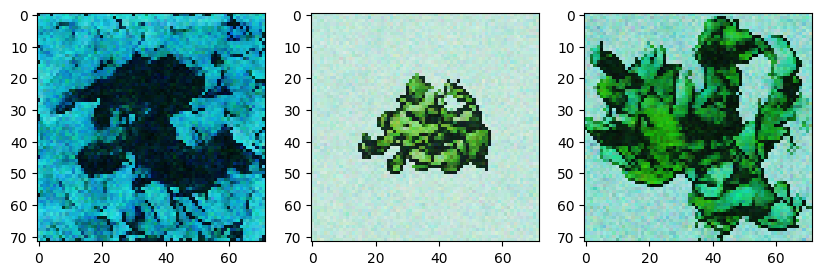

0.02115126:  57%|██████████████████████████████████████████████████████████████████                                                  | 57000/100001 [1:59:18<1:27:27,  8.19it/s]

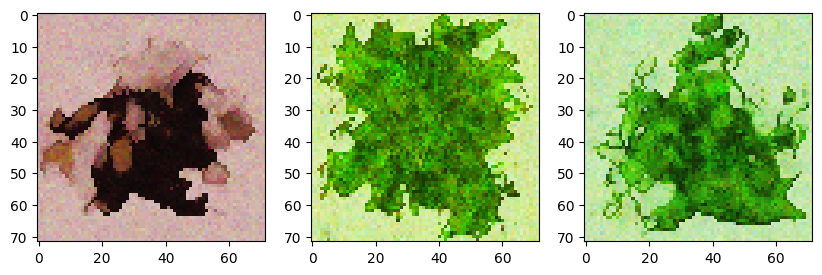

0.01974376:  58%|███████████████████████████████████████████████████████████████████▎                                                | 58000/100001 [2:01:24<1:25:20,  8.20it/s]

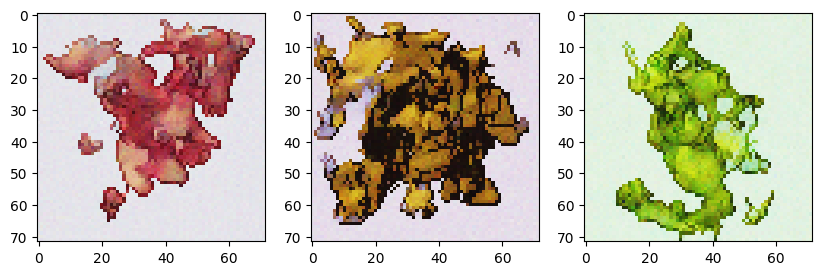

0.02429106:  59%|████████████████████████████████████████████████████████████████████▍                                               | 59000/100001 [2:03:30<1:23:29,  8.18it/s]

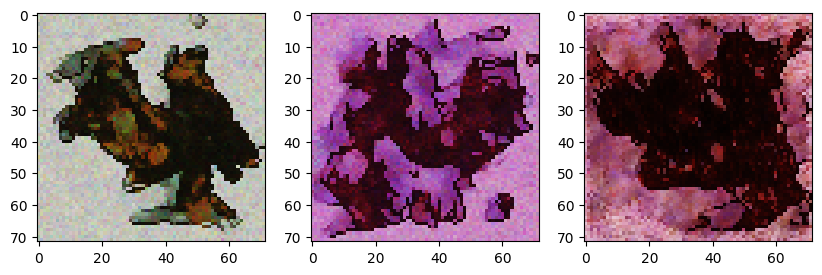

0.02354439:  60%|█████████████████████████████████████████████████████████████████████▌                                              | 60000/100001 [2:05:35<1:21:28,  8.18it/s]

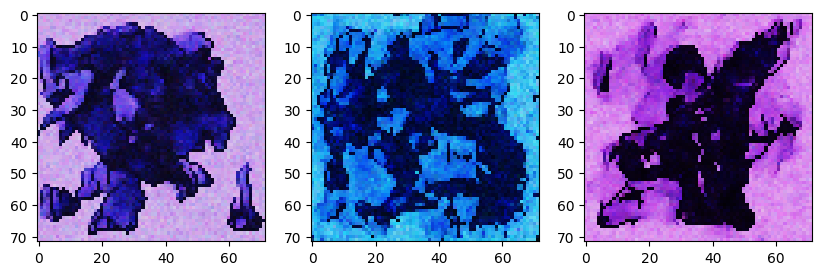

0.02519432:  61%|██████████████████████████████████████████████████████████████████████▊                                             | 61000/100001 [2:07:41<1:19:27,  8.18it/s]

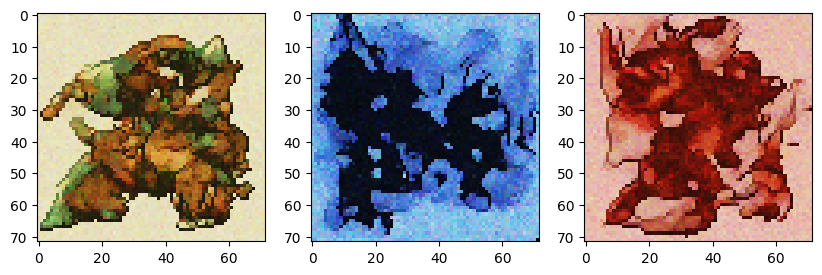

0.02305119:  62%|███████████████████████████████████████████████████████████████████████▉                                            | 62000/100001 [2:09:47<1:17:27,  8.18it/s]

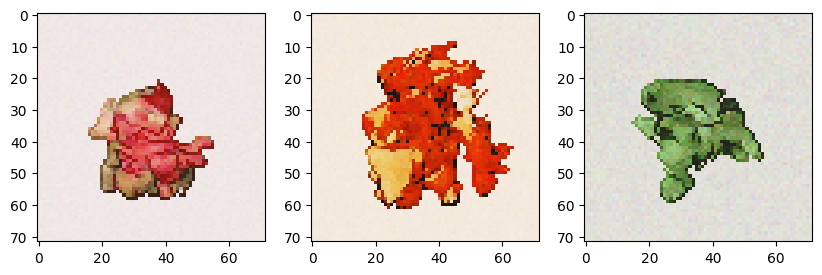

0.01054266:  63%|█████████████████████████████████████████████████████████████████████████                                           | 63000/100001 [2:11:52<1:15:16,  8.19it/s]

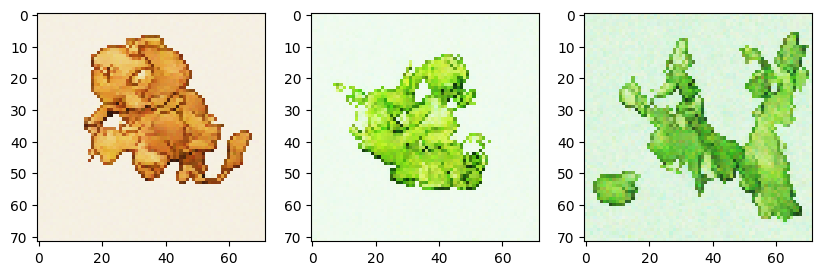

0.01384124:  64%|██████████████████████████████████████████████████████████████████████████▏                                         | 64000/100001 [2:13:58<1:13:21,  8.18it/s]

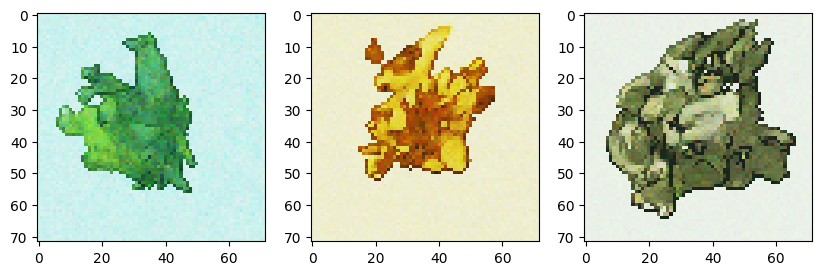

0.01589081:  65%|███████████████████████████████████████████████████████████████████████████▍                                        | 65000/100001 [2:16:03<1:11:08,  8.20it/s]

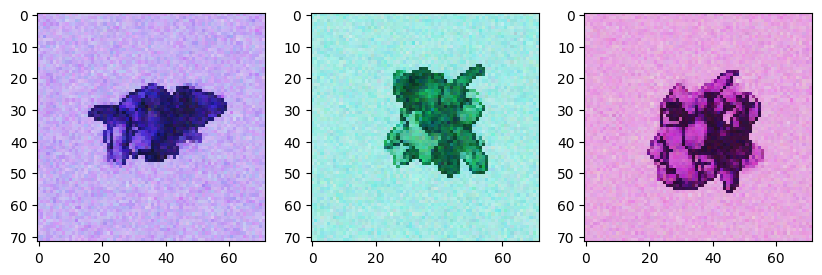

0.02004842:  66%|████████████████████████████████████████████████████████████████████████████▌                                       | 66000/100001 [2:18:09<1:09:15,  8.18it/s]

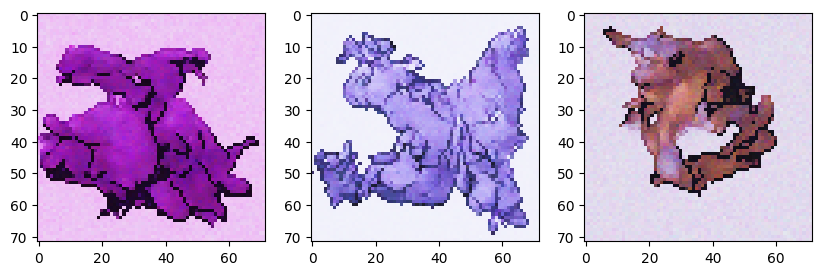

0.01692591:  67%|█████████████████████████████████████████████████████████████████████████████▋                                      | 67000/100001 [2:20:15<1:07:02,  8.20it/s]

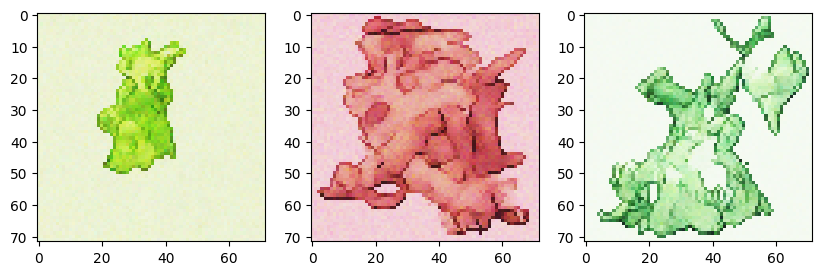

0.02001406:  68%|██████████████████████████████████████████████████████████████████████████████▉                                     | 68000/100001 [2:22:20<1:05:14,  8.18it/s]

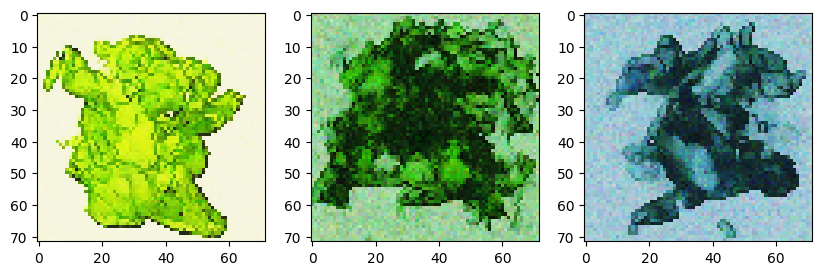

0.01438548:  69%|████████████████████████████████████████████████████████████████████████████████                                    | 69000/100001 [2:24:26<1:03:07,  8.19it/s]

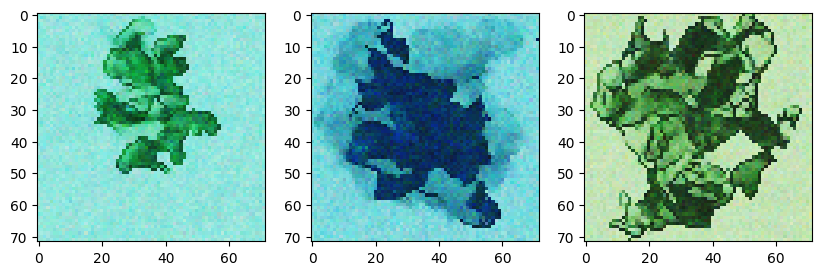

0.02013777:  70%|█████████████████████████████████████████████████████████████████████████████████▏                                  | 70000/100001 [2:26:31<1:00:58,  8.20it/s]

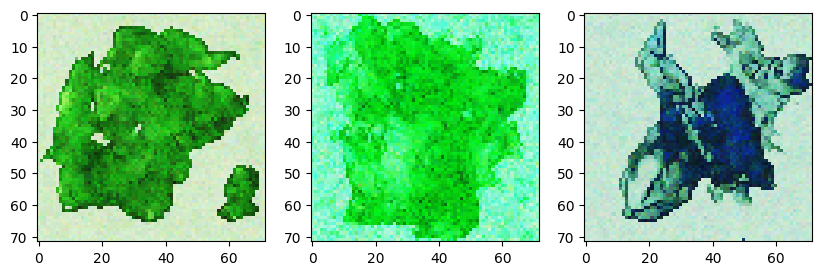

0.01859949:  71%|███████████████████████████████████████████████████████████████████████████████████▊                                  | 71000/100001 [2:28:37<58:51,  8.21it/s]

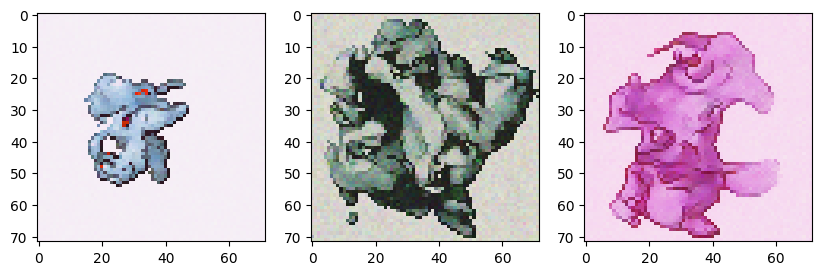

0.01125293:  72%|████████████████████████████████████████████████████████████████████████████████████▉                                 | 72000/100001 [2:30:43<56:59,  8.19it/s]

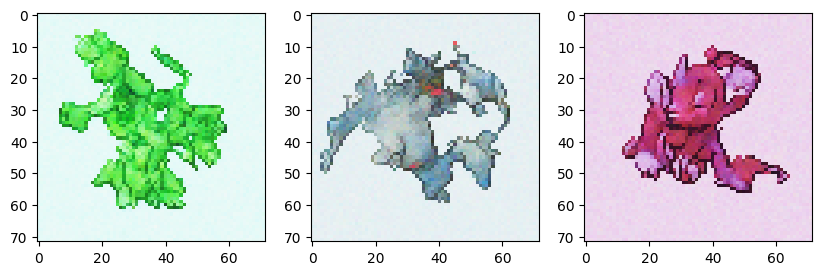

0.02187075:  73%|██████████████████████████████████████████████████████████████████████████████████████▏                               | 73000/100001 [2:32:48<54:58,  8.19it/s]

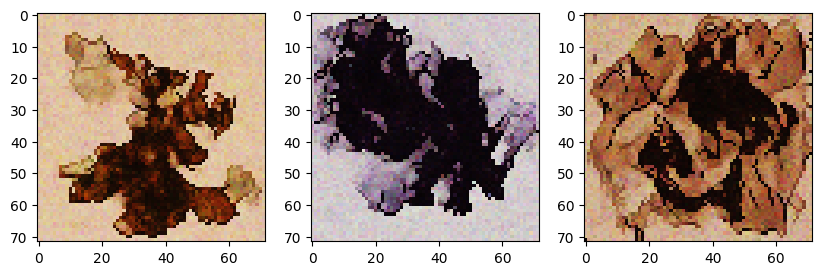

0.02341670:  74%|███████████████████████████████████████████████████████████████████████████████████████▎                              | 74000/100001 [2:34:54<52:50,  8.20it/s]

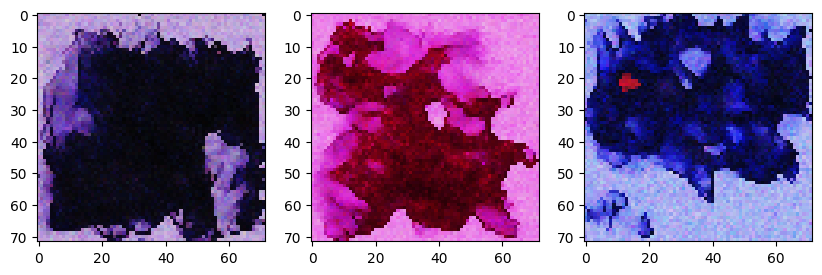

0.02003586:  75%|████████████████████████████████████████████████████████████████████████████████████████▍                             | 75000/100001 [2:37:00<50:57,  8.18it/s]

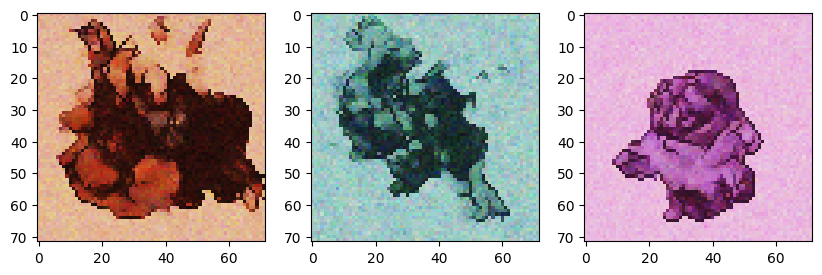

0.00546274:  76%|█████████████████████████████████████████████████████████████████████████████████████████▋                            | 76000/100001 [2:39:05<48:48,  8.20it/s]

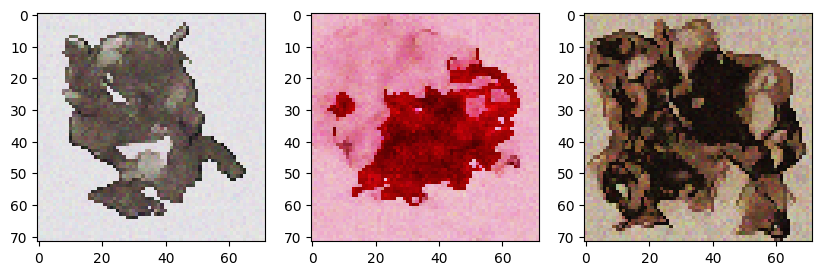

0.01504286:  77%|██████████████████████████████████████████████████████████████████████████████████████████▊                           | 77000/100001 [2:41:11<46:45,  8.20it/s]

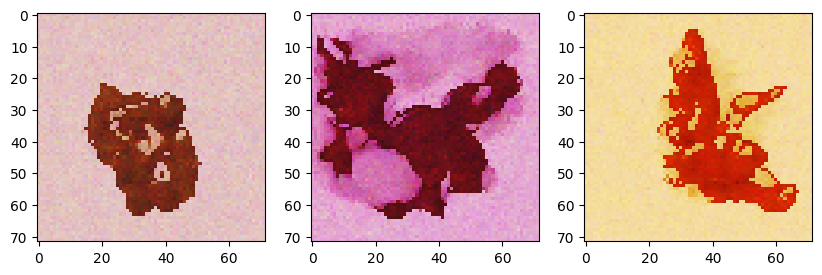

0.01254108:  78%|████████████████████████████████████████████████████████████████████████████████████████████                          | 78000/100001 [2:43:17<44:48,  8.18it/s]

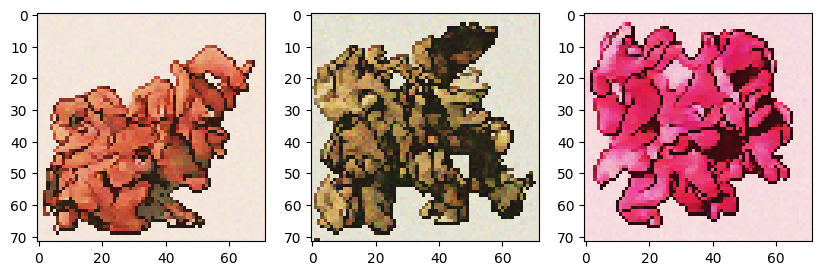

0.01488360:  79%|█████████████████████████████████████████████████████████████████████████████████████████████▏                        | 79000/100001 [2:45:22<42:49,  8.17it/s]

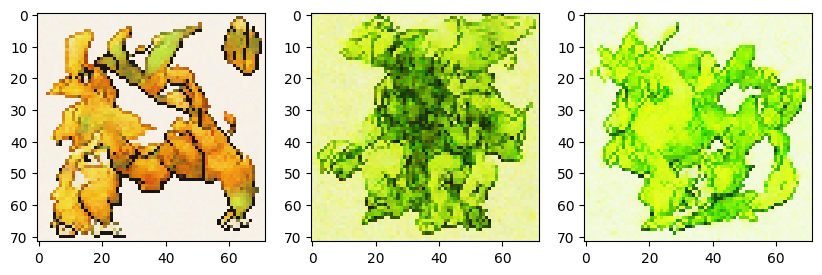

0.01498498:  80%|██████████████████████████████████████████████████████████████████████████████████████████████▍                       | 80000/100001 [2:47:28<40:40,  8.19it/s]

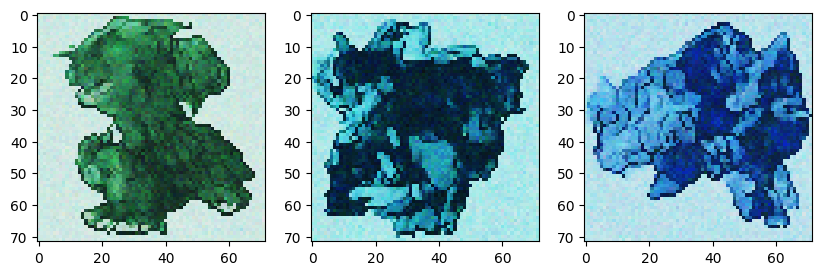

0.00959042:  81%|███████████████████████████████████████████████████████████████████████████████████████████████▌                      | 81000/100001 [2:49:33<38:40,  8.19it/s]

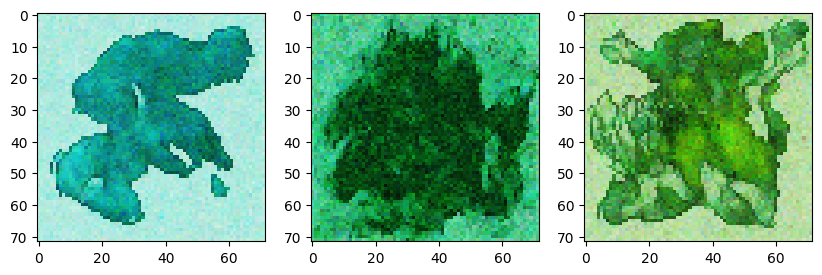

0.02103579:  82%|████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 82000/100001 [2:51:39<36:32,  8.21it/s]

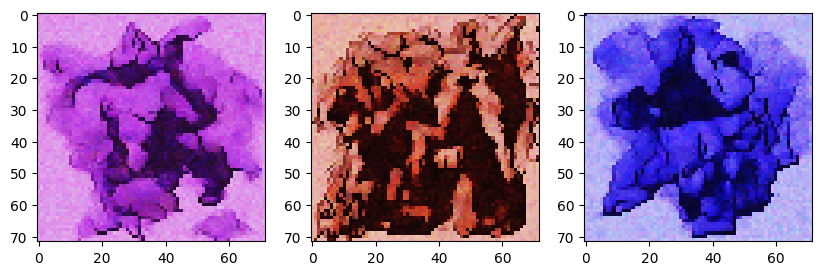

0.02007274:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 83000/100001 [2:53:45<34:32,  8.20it/s]

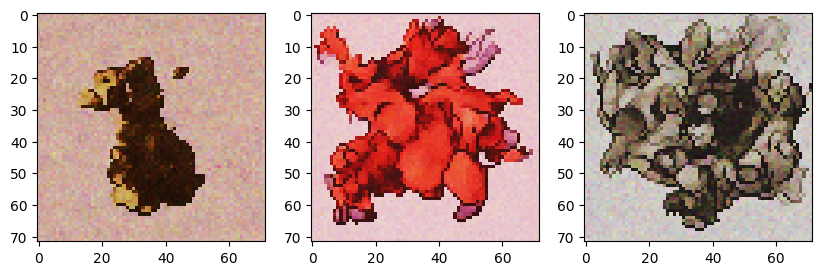

0.01402522:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████                   | 84000/100001 [2:55:50<32:35,  8.18it/s]

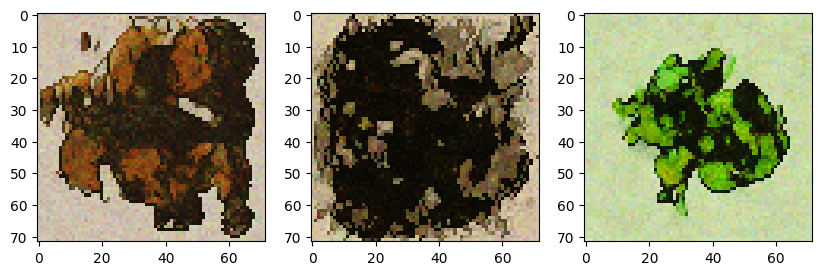

0.01291972:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 85000/100001 [2:57:56<30:28,  8.20it/s]

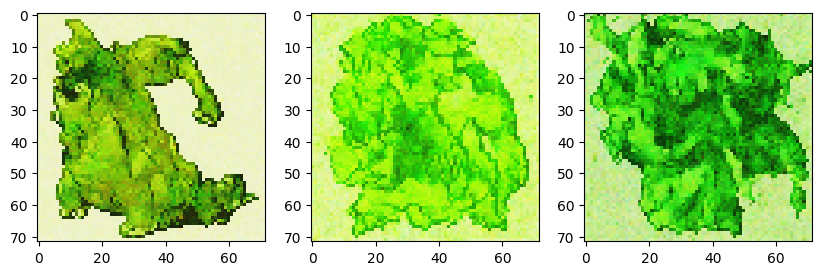

0.02096447:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 86000/100001 [3:00:02<28:31,  8.18it/s]

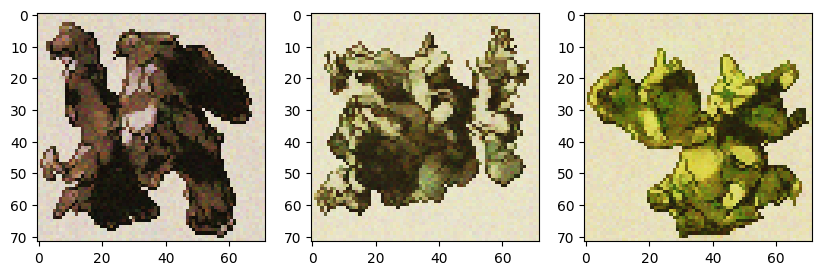

0.00982976:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 87000/100001 [3:02:07<26:24,  8.21it/s]

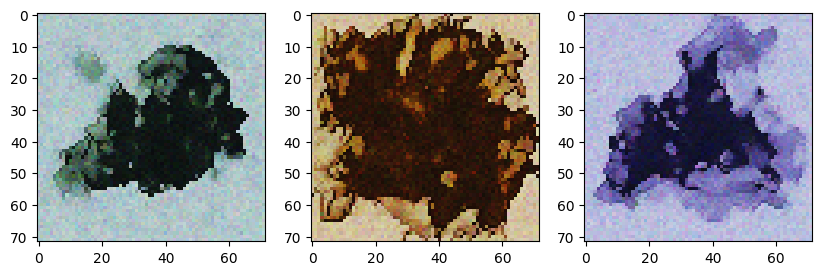

0.01169056:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 88000/100001 [3:04:13<24:27,  8.18it/s]

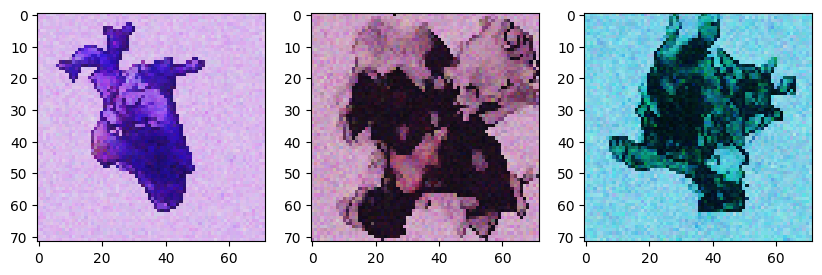

0.01679141:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████             | 89000/100001 [3:06:19<22:26,  8.17it/s]

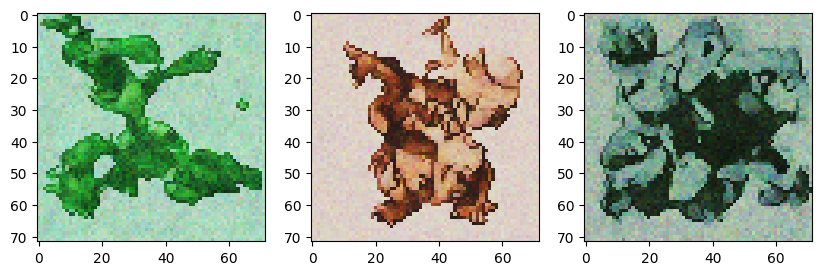

0.01488543:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 90000/100001 [3:08:24<20:19,  8.20it/s]

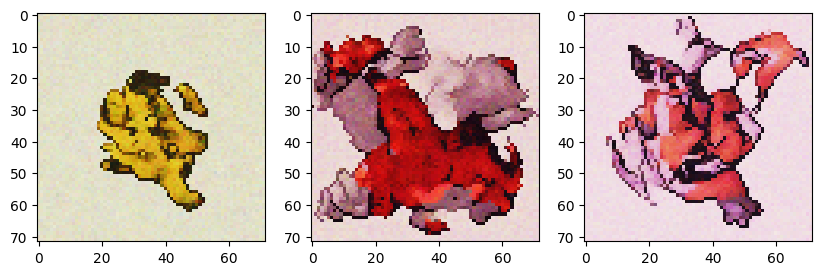

0.01395212:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 91000/100001 [3:10:30<18:18,  8.19it/s]

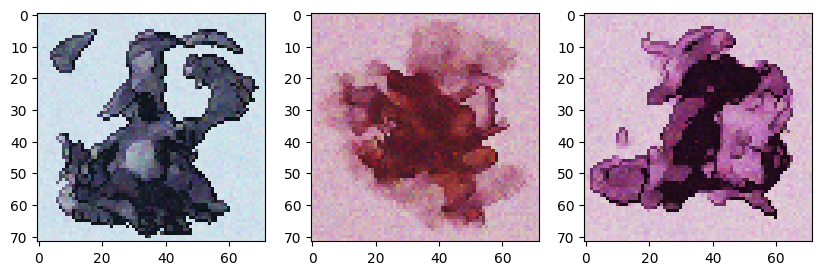

0.02193508:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 92000/100001 [3:12:35<16:16,  8.20it/s]

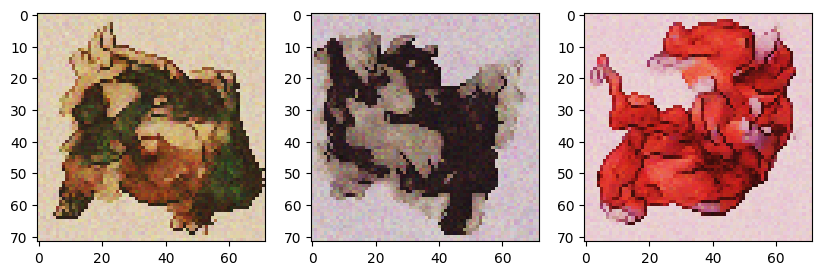

0.01758843:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 93000/100001 [3:14:41<14:15,  8.18it/s]

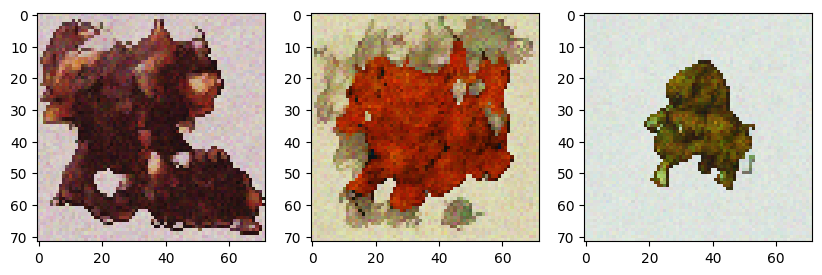

0.00654129:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 94000/100001 [3:16:47<12:14,  8.17it/s]

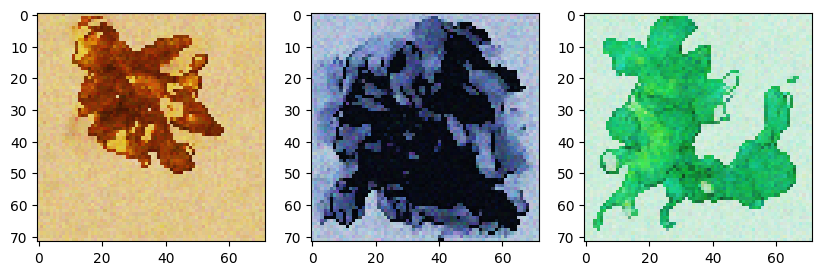

0.00776388:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 95000/100001 [3:18:52<10:09,  8.20it/s]

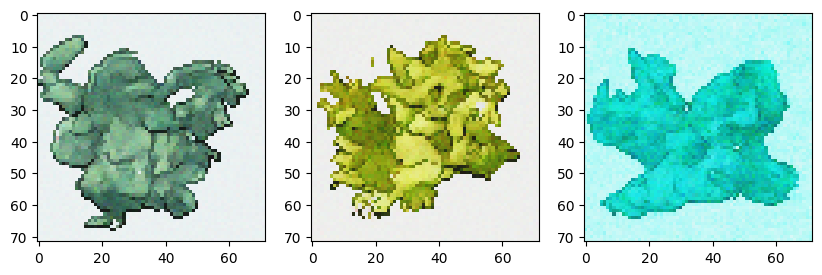

0.01570213:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 96000/100001 [3:20:58<08:09,  8.17it/s]

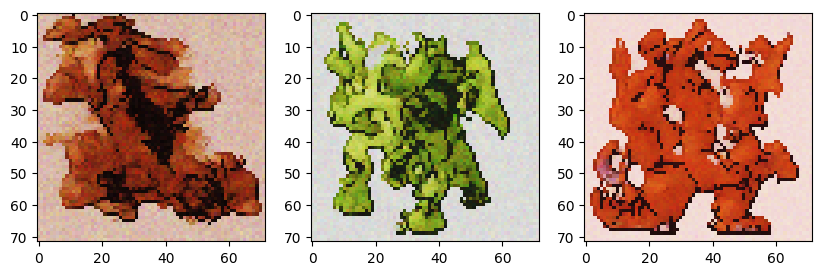

0.01150421:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 97000/100001 [3:23:03<06:05,  8.20it/s]

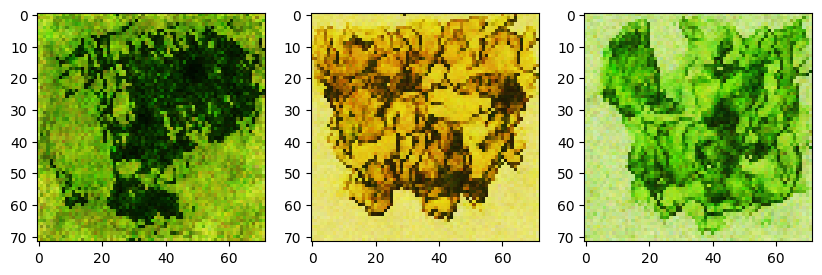

0.01956800:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 98000/100001 [3:25:09<04:04,  8.19it/s]

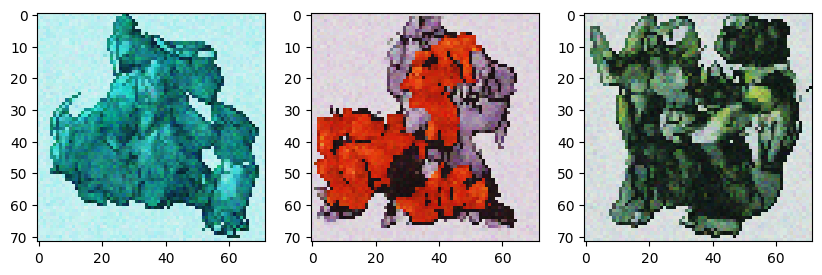

0.01015124:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 99000/100001 [3:27:15<02:02,  8.19it/s]

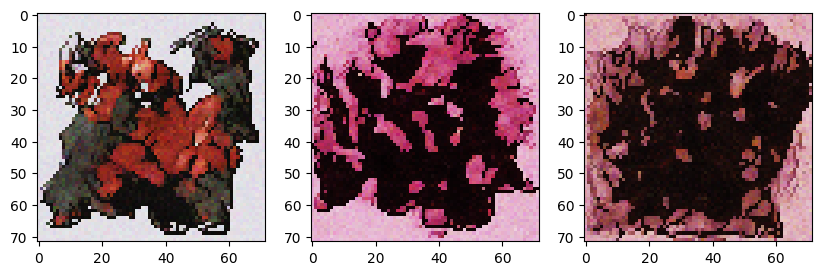

0.02339846: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 100000/100001 [3:29:20<00:00,  8.23it/s]

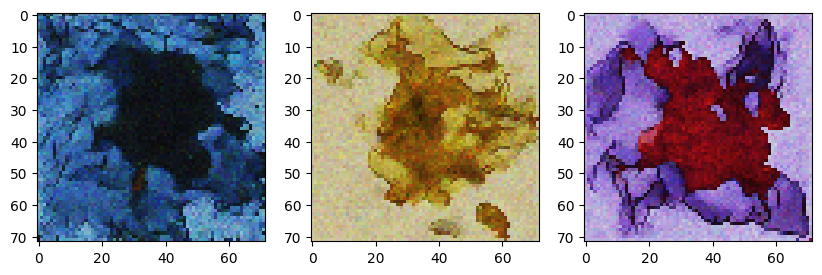

0.02423315: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100001/100001 [3:29:24<00:00,  7.96it/s]


In [8]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
pbar = tqdm(range(100001))
def closure():
    optimizer.zero_grad()

    bs = 8

    source = randint(0, 2)
    batch = torch.randperm(385)[:bs]
    x0 = pimages[source, batch]
    x0 = torch.stack([transform(x) for x in x0], dim=0)
    x0 = isigmoid(x0)

    ty = types[batch]
    
    e = torch.randn_like(x0)
    t = torch.randint(0, T - 1, (bs,), device=device)

    xt = torch.sqrt(alpha_[t])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[t])[:, None, None, None] * e
    ep = model(xt, t, ty)

    loss = loss_func(ep, e)
    loss.backward()
    
    pbar.set_description(f"%.8f" % loss, refresh=False)
    
    return loss

model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 1000 == 0:
        generate_image()

torch.save(model.state_dict(), 'model.pt')